# Chapter 5

## Counterfactual Quantities

## Theorem 5.2.1 -- Structural Basis Expansion of Counterfactuals
Consider an SCM $M^*$ and a counterfactual distribution computed from it,
$$P[Y_C|E]$$
where E is the factual evidence, C is the counterfactual condition, and Y is the outcome variable.

We can write the structural basis expansion:
$$\sum_u 1[Y_C (u) = y]P(u|E=e)$$



We can understand this through a three-step counterfactual evaluation:

1. **Abduction.** Based on the factual evidence E = e, the posterior distribution over th eunits can be computed to better explain the evidence, namely, $P(U|E=e)$.
   
2. **Intervention.** Based on the counterfactual condition, C = c, the corresponding sub-model, $F_{C=c}$ can be generated.
   
3. **Evaluation.** With a new probability distribution over the exogenous (from step 1) and a new collection of mechanisms (from step 2), both over the same set of endogenous and exogenous variables, a new SCM is induced, namely:
$$M' = (U, V, F_{C=c},P(U|E))$$

In [1]:
from scm import SymbolicSCM
import sympy as sp

## Effect of the Treatment on the Treated (ETT)

The ETT mixes the natural and the counterfactual words, or variations in layers 1 and 2, and is written as follows:

$$P(Y_{X=x}|X=x')$$

We can write the structural basis expansion:

$$\sum_u 1[Y_{X=x}(u)=y]P(U|X=x')$$

### Example 5.3 -- Job Re-training Program

The government is considering funding a new re-training program to get unemployed citizens back into the workforce by acquiring new skills to build AI systems. The structural model describing this population is given below:

In [2]:
x, y, u = sp.symbols('x y u')

scm_5_3 = SymbolicSCM(
    f = {
        x: sp.Piecewise((0, u < 2), (1, True)),
        y: sp.Piecewise((x, sp.Eq(u,0) | sp.Eq(u,2)), (1 - x, sp.Eq(u,1) | sp.Eq(u,3)), (1, True))
    },
    
    pu ={
        u: [9/40,7/40,1/5,1/5,1/5]
    }
)

The variable X represents whether the person enrolled in the program, and Y whether the person was able to find a new job one year after graduating.

Evidence shows that the program is effective:

In [3]:
y_x1 = scm_5_3.do({x:1}).v['y']

y_x0 = scm_5_3.do({x:0}).v.y

In [4]:
scm_5_3.query({y_x1:1}) - scm_5_3.query({y_x0:1}) > 0

True

Hiring rate among the program participants turns out to be even higher than in the original pilot study, formally:

In [5]:
scm_5_3.query({y:1},given={x:1}) - scm_5_3.query({y_x1:1}) > 0

True

Yet, those who self-enroll, critics say, are more resourceful, more intelligent, and socially more
connected than the eligible who did not enroll and are more likely to have found a job regardless
of whether receiving or not the training.

Mathematically, the data scientist suggests we need to estimate the program’s differential ben-
efit on those who enrolled. To what extent does the hiring rate increase among those who enroll,
compared to what it would have been had they not been trained, which is written as the following
ETT contrast:

In [6]:
scm_5_3.query({y_x1:1},given={x:1}) - scm_5_3.query({y_x0:1},given={x:1}) > 0

False

In other words, this contrast compares two different counterfactual worlds for units that would naturally join the training program, $X = 1$.

It relates to the difference in their employability (outcome $Y$) had they enroll ($do(X = 1)$) versus
not enroll ($do(X = 0)$) into the program, or $Y_{X=1}$ versus $Y_{X=0}$.

## Probabilities of Necessity & Sufficiency

We now consider a pair of quantities known as the probability of necessity (PN) and the probability
of sufficiency (PS), which are written as:

$$PS(X;Y) = P(Y_{X=1}=1|X=0,Y=0)$$
$$PN(X;Y) = P(Y_{X=0}|X=1,Y=1)$$

PS encodes how much the presence of X is sufficient to make Y = 1.

PN encodes how much the presence of X was necessary to make Y = 1.
\
\
\
We can define this more generally as:
$$PN/PS_{(x,y),(x',y')}(X;Y) = P(Y_{X=x} | X=x', Y=y')$$

Through structural basis decomposition, we obtain:
$$\sum_u 1[Y_{X=x}(u)=y]P(u|X=x',Y=y')$$

### Example 5.5 -- Medical Decisions

Consider an example that appears in the context of medical decision-making:

In [7]:
x, y, z, ur, ux, uy, uz = sp.symbols('x y z ur ux uy uz')

scm_5_5 = SymbolicSCM(
    f = {
        z: ur & uz,
        x: ~(z ^ ux),
        y: (x & ur) | (~x & ur & uy) | (~x & ~ur & ~uy)
    },
    pu = {
        ur: .25,
        uz: .95,
        ux: .9,
        uy: .7
    }
)
        

where $X$ represents a drug, $Y$ the outcome of survival, and $Z$ the presence or not of a symptom (hypertension). $U_r$ represents whether a person has a specific natural resistance to the disease, and $U_x, U_y, U_z$ are sources of variations outside the model affecting $X, Y, Z$, respectively.

In [8]:
scm_5_5_do_x0 = scm_5_5.do({x:0})

scm_5_5_do_x1 = scm_5_5.do({x:1})

In [9]:
df = scm_5_5.get_probability_table(include_u=True)
df_x0 = scm_5_5_do_x0.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df_x1 = scm_5_5_do_x1.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df.insert(len(df.columns) - 1,df_x0.name,df_x0)
df.insert(len(df.columns) - 1,df_x1.name,df_x1)

table_5_5 = df

In [10]:
scm_5_5.query({y:1},given={x:1}) - scm_5_5.query({y:1},given={x:0}) > 0

True

One may seem to conclude that because the probability of survival ($Y=1$) given that one took the drug ($X=1$) is higher than without ($X=0$), that the drug has a positive effect. At this point though, our readers know better, so we look at the causal effect of the drug:

In [11]:
y_x1 = scm_5_5_do_x1.v.y
y_x0 = scm_5_5_do_x0.v.y

scm_5_5.query({y_x1:1}) - scm_5_5.query({y_x0:1}) > 0

False

Thus, interventionally speaking, the drug has a negative (average) effect in the population.

Since there is a group of patients who did not receive the treatment and died ($X=0, Y=0$), one may wonder whether these patients would have been alive ($Y=1$) had they been given the treatment ($X=1$). This corresponds to the probability of sufficiency:

In [12]:
scm_5_5.query({y_x1:1},given={x:0,y:0})

0.021739130434782622

The conclusion from this analysis is clear: even if everyone who did not survive were treated, only
around 2% would have survived. In other words, the drug would not have prevented their death.

Another aspect of this situation worth examining is whether the treatment would have been
harmful to those who did not get it and still survived:

In [13]:
scm_5_5.query({y_x1:1},given={x:0,y:1})

0.10792951541850222

Which means about 90% of such people would have died had they been given the treatment.

## Probabilities of Causation (Probabilities of Neccessity and Sufficiency)

Note that the units passed through only one interventional world $F_{X=x}$ when discussing PN and PS individually, while the units go through two interventional worlds in the context of PNS. More specifically, PNS is written as:
$$PNS_{(x,x'),(y,y')}(X;Y) = P(Y_{X=x}=y,Y_{X=x'}=y')$$
PNS is the probability that Y would response to X in both ways, that is, for Y to get value y under some intervention *do*(X=x) while at the same time taking value y' under another intervention *do*(X=x'). Therefore, it measures botht he necessity and suffiency of X to produce Y.


Applying the structural basis decompsition, we obtain:
$$\sum_u 1[Y_{X=x}(u) = y, Y_{X=x'}(u) = y']P(u)

### Example 5.6 -- Medical Decision (revisited)

Recall the discussion from example 5.5 where we considered the effectiveness of a treatment in preventing death in patients suffering from a certain disease.

In this context, the PNS measures how much the treatment can affect the survival of patients by them surviving when administered and them dying when not administered. We find:

In [14]:
scm_5_5.query({y_x1:1,y_x0:0})

0.075

This means that only 7.5% of the population will survive because of the treatment. That is, this
portion of the population will survive if and only if they receive the treatment. In other words, if a
patient is chosen at random, there is a 7.5% chance that such a patient would die if he does not get
treatment and survive if treated.

## Direct and Indirect Effects

Distentangling effects into their direct and indirect components allow us to reason about *how* a system works by understanding more specific parts of how Y responds to induced variations on X.

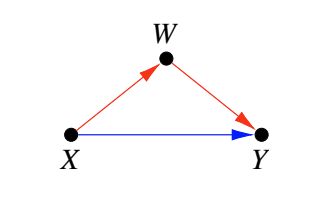

Figure 5.8: Causal diagram with treatment X,
outcome Y, and mediator W. The direct path
is shown in blue, and the
indirect one is shown in
red.

We define two counterfactuals, the Natural Direct Effect (NDE) and the Natural Indirect Effect (NIE) that capture the notions of direct and indirect effects. Both quantities represent constrasts and are defined as follows:
$$NDE_{x_0,x_1}(y) = P(y_{x_1,W_{x_0}}) - P(Y_{x_0})$$
$$NIE{x_0,x_1}(y) = P(y_{x_0,W_{x_1}}) - P(Y_{x_0})$$

For the NDE, the counterfactual $P(y_{x_1,W_{x_0}})$ refers to the outcome $Y$ under $X = x_1$ and $W = W_{x_0}$, the value that $W$ would attain had $X$ been $x_0$.

For the NIE, the counterfactual $P(y_{x_0,W_{x_1}})$ refers to the outcome $Y$ under $X = x_0$ and $W = W_{x_1}$, the value that $W$ would attain had $X$ been $x_1$.

$Y_{x_0}$ represents a baseline where $Y$ perceives $X$ as $x_0$ in all causal paths. It is equivalent to $Y_{x_0,W_{x_0}}$, a situation where $W$ gets the same $X=x_0$.
\
\
\
The structural basis expansion can be written as follows:
$$NDE_{x_0,x_1}(y) = \sum_u 1[y_{x_1,W_{x_0}}(u)] - 1[Y_{x_0}(u)] P(u)$$
$$NIE_{x_0,x_1}(y) = \sum_u 1[y_{x_0,W_{x_1}}(u)] - 1[Y_{x_0}(u)] P(u)$$

### Example 5.7 -- Exercise and Cholesterol

Consider the following diagram:

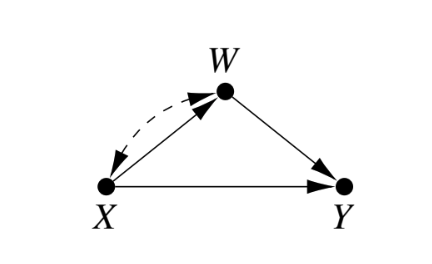

Suppose $X$ is the level of exercise (sufficient or insufficient), $W$ cholesterol levels (low or high), and $Y$ cardiovascular disease (present or not present).

We define the SCM as follows:

In [15]:
x, w, y, uwx, ux, uw, uy = sp.symbols('x w y uwx ux uw uy')

scm_5_7 = SymbolicSCM(
    f = {
        x: ux | uwx,
        w: (x & uwx) | (~x & uw),
        y: (~x & w) | (w & uy) | ~w
    },
    pu = {
        ux: .6,
        uwx: .3,
        uw: .5,
        uy: .1,
    }
)

An interesting question is how much exercise prevents the disease by means other than regulating cholesterol. This can be represented with the NDE. This query is identifiable and given by the expression:
$$\sum_w (P(y|x',w) - P(y|x,w))P(w|do(x))$$

We can calculate this expression using this identification expression:

In [16]:
scm_5_7_do_x0 = scm_5_7.do({x:0})

w_x0 = scm_5_7_do_x0.v.w

prob = 0

for w_val in range(2):
    prob += (scm_5_7.query({y:1},given={x:1,w:w_val}) - scm_5_7.query({y:1},given={x:0,w:w_val})) * scm_5_7.query({w_x0:w_val})
    
prob

-0.44999999999999996

Or by directly accessing the counterfactual words implied by the NDE:

In [17]:
y_x1_wx0 = scm_5_7.do({x:1,w:w_x0}).v.y

y_x0 = scm_5_7_do_x0.v.y

scm_5_7.query({y_x1_wx0:1}) - scm_5_7.query({y_x0:1})

-0.44999999999999996

This means that the direct effect of exercise ($X=1$) is to lower the probability of cardiovascular disease ($Y=1$) by 45%.

Analogously, the NIE refers to the question of how much the benefits of exercising on cardiovascular disease are due to the regulation of cholesterol. From the causal graph, this is identifiable as:

$$\sum_w P(y|x,w)(P(w|do(x')) - P(w|do(x)))$$

We can calculate this using the identification expression:

In [18]:
scm_5_7_do_x1 = scm_5_7.do({x:1})

w_x1 = scm_5_7_do_x1.v.w

prob = 0

for w_val in range(2):
    prob += scm_5_7.query({y:1},given={x:0,w:w_val}) * (scm_5_7.query({w_x1:w_val}) - scm_5_7.query({w_x0:w_val}))
    
prob

0.0

As before, we can also directly access the counterfactual worlds:

In [19]:
y_x0_wx1 = scm_5_7.do({x:0,w:w_x1}).v.y

scm_5_7.query({y_x0_wx1:1}) - scm_5_7.query({y_x0:1})

0.0

This means that the indirect effect of exercise on cardiovascular disease through the regulation of cholesterol does not alter the probability at all of cardiovascular disease at all.

## Path-Specific Effects

The NDE selects the direct path $X \rightarrow Y$ while the NIE selects all causal paths between X and Y but the direct one. Generally, counterfactuals can be used to reason about effects carried by a selected subset of edges, called *path-specific* events.

### Example 5.8 -- Education Cost on Debt

Consider the following causal diagram:

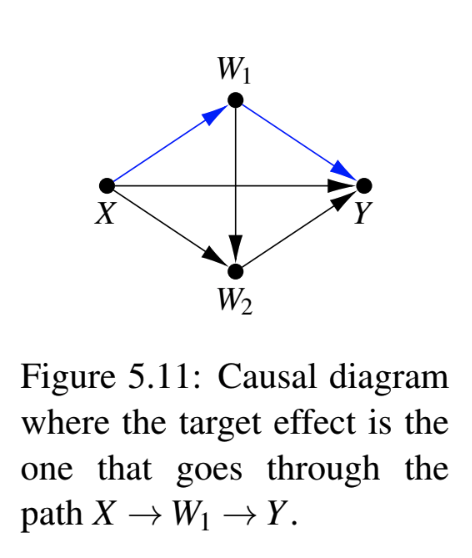

where $X$ represents choice of career (positive or negative), $W_1$ represents institution where one receives education (sufficient or insufficient), $W_2$ is the job attained after graduation (sufficient or insufficient), and $Y$ a person's debt (low or high).

The SCM is defined as follows:

In [20]:
x, w1, w2, y, ux, uw1, uw2, uy = sp.symbols('x w1 w2 y ux uw1 uw2 uy')

scm_5_8 = SymbolicSCM(
    f = {
        x: ux,
        w1: uw1,
        w2: uw2,
        y: (x & ~w1 & ~w2) | (~x & w1 & ~w2) | (~x & ~w1 & w2) | ~x
    },
    pu = {
        ux: .5,
        uw1: .3,
        uw2: .7,
        uy: .1
    }
)

Suppose the government is planning to lower people’s debt by partially paying off student loans. To do so, they want to assess the hypothetical situation where a
person chooses their career, institution, and job, but the cost generated by attending the institution
is set to the level of a low (or zero) cost program. In graphical terms, this is to assess the effect of
the path $X \rightarrow W_1 \rightarrow Y$.

This path-specific effect can be written as the following counterfactual:

$$P(Y_{X,W_2,W_{1[x']}}) = P(Y_{W_{1[x']}})$$

In [21]:
w_x1 = scm_5_8.do({x:1}).v.w1

y_wx1 = scm_5_8.do({w1:w_x1}).v.y

scm_5_8.query({y_wx1:1})

0.6049999999999999

This captures the path-specific event probability of low debt ($Y=1$) as controlled by sufficient education ($W=1$) having been intervened with a positive career choice ($do(X=1)$). Since $X$ and $W_2$ take on their natural values, they are not considered in the evaluation of the counterfactual world.